# Galaxy Generation Tool

1. Adjust the SYSTEMS_COUNT variable (recommended value range is 17-22, for more systems you might have to adjust the scale or min system distance as well).
2. Execute the first cell as many times as you want to obtain desired system layout.
3. Execute the second cell to preview the generated star and planet types for systems.
4. Execute the third cell in order to obtain the preliminary JSON data.
5. Fill out the system and colony planet names, as well as factions, add space stations.
6. Append the resulting sector to `data/game/galaxy/systems.json`.

### Generate points and connections

### Randomize star and planet types

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from string import ascii_uppercase

SYSTEMS_COUNT = 20
SCALE_X = 255
SCALE_Y = 255
MIN_DISTANCE = (SCALE_X + SCALE_Y) / 11


def generate_points(num_points):
    points = []
    point_labels = {}
    label_counter = 0
    while len(points) < num_points:
        point = tuple(
            map(int, np.multiply(np.random.rand(2), np.array((SCALE_X, SCALE_Y))))
        )
        
        if all(
            pdist([point, existing_point]) >= MIN_DISTANCE for existing_point in points
        ):
            points.append(point)
            point_labels[point] = ascii_uppercase[label_counter]
            label_counter += 1
    return points, point_labels


def generate_connections(points):
    connections = []
    dist_matrix = squareform(pdist(points))
    for i in range(len(points)):
        sorted_indices = np.argsort(dist_matrix[i])
        closest_points_indices = [idx for idx in sorted_indices if idx != i]
        num_connections = np.random.choice([1, 2, 3, 4], p=[0.2, 0.5, 0.25, 0.05])
        for index in closest_points_indices[:num_connections]:
            connection = (min(i, index), max(i, index))
            if connection not in connections:
                connections.append(connection)
    return connections


def plot_systems(points, connections):
    np_points = np.array(points)
    plt.scatter(np_points[:, 0], np_points[:, 1], color="red")
    for point in points:
        plt.annotate(
            point_labels[point],
            point,
            textcoords="offset points",
            xytext=(0, 10),
            ha="center",
        )

    for connection in connections:
        point1 = points[connection[0]]
        point2 = points[connection[1]]
        plt.plot([point1[0], point2[0]], [point1[1], point2[1]], color="gray")

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()


points, point_labels = generate_points(SYSTEMS_COUNT)
connections = generate_connections(points)

plot_systems(points, connections)

cell1finished = True
if "cell2finished" in globals():
    del cell2finished

A - id_star_m: ['id_planet_gas_giant', 'id_planet_tomb']
[(26, 41), (156, 13)]
B - id_star_neutron: ['id_planet_unique']
[(164, 146), (195, 55), (203, 116)]
C - id_star_b: ['id_planet_paradise']
[(164, 146), (219, 215), (175, 247)]
D - id_star_m: ['id_planet_tomb', 'id_planet_tomb', 'id_planet_barren']
[(20, 196), (109, 218)]
E - id_star_g: ['id_planet_tomb', 'id_planet_barren', 'id_planet_barren']
[(56, 88), (20, 196)]
F - id_star_g: ['id_planet_molten', 'id_planet_tomb', 'id_planet_tomb']
[(203, 116), (219, 215)]
G - id_star_m: ['id_planet_frozen', 'id_planet_frozen', 'id_planet_tomb']
[(85, 20), (56, 88)]
H - id_star_m: ['id_planet_tomb', 'id_planet_tomb']
[(66, 177), (164, 146)]
I - id_star_m: ['id_planet_barren', 'id_planet_colony']
[(108, 157), (20, 196), (109, 218)]
J - id_star_m: ['id_planet_barren', 'id_planet_frozen', 'id_planet_frozen']
[(17, 122), (26, 41)]
K - id_star_a: ['id_planet_colony']
[(151, 91), (243, 47), (248, 0), (156, 13)]
L - id_star_black_hole: []
[(47, 245),

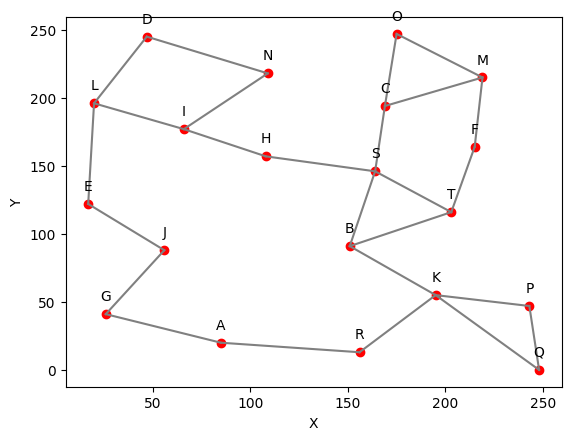

In [71]:
if "cell1finished" not in globals():
    from warnings import filterwarnings

    filterwarnings("ignore", category=UserWarning)
    raise SystemExit("Please run the first cell first.")

import json
from os import path
from pprint import pprint
from math import isclose
import random

data_dir = path.abspath(path.join(__vsc_ipynb_file__, "../../../data"))
planets_data_path = path.join(data_dir, "game/galaxy/planets.json")
stars_data_path = path.join(data_dir, "game/galaxy/stars.json")


def get_json_data(json_file_path, property_name):
    with open(json_file_path, "r") as file:
        json_data = json.load(file)[property_name]
        return json_data


def get_planets_data():
    json_data = get_json_data(planets_data_path, "planetTypes")
    planets = []
    for planet in json_data:
        planets.append(planet)

    return planets


def get_star_planet_range(json_star_data):
    planet_range_str = json_star_data["planetCount"]
    return list(map(int, planet_range_str.split("-")))


def get_stars_planet_data(planets_data):
    json_data = get_json_data(stars_data_path, "starTypes")
    stars = {}
    star_weights = {}
    planet_ranges = {}
    for star in json_data:
        stars[star] = json_data[star]["planetProbabilities"]
        star_weights[star] = json_data[star]["weight"]
        planet_ranges[star] = get_star_planet_range(json_data[star])

        unspec_planets_n = sum(planet not in stars[star] for planet in planets_data)
        total_specified_probability = sum(stars[star].values())

        if not isclose(total_specified_probability, 1):
            unspecified_probability = (
                1 - total_specified_probability
            ) / unspec_planets_n
            for planet in planets_data:
                if planet not in stars[star]:
                    stars[star][planet] = unspecified_probability

    return stars, star_weights, planet_ranges


def generate_stars(points, star_weights):
    systems = []
    for star_coords in points:
        random_star_type = random.choices(
            population=list(star_weights.keys()), weights=list(star_weights.values())
        )[0]
        systems.append((random_star_type, star_coords, [], []))
        # star type, coords, planets, connections, yes I know this should've been a class or something
    return systems


def generate_planets(json_star_data, planet_count):
    while True:
        planets = random.choices(
            population=list(json_star_data.keys()),
            weights=list(json_star_data.values()),
            k=planet_count,
        )
        if planets.count("id_planet_colony") < 2:
            break
    return planets

def fill_connection_data(system_idx, connections_arr):
    for connection in connections:
        if system_idx in connection:
            connections_arr.append( points[ connection[0] if connection[0] != system_idx else connection[1] ] )

def generate_systems_data(stars_data, star_weights, planet_ranges, points, connections):
    systems = generate_stars(points, star_weights)

    for idx, system_data in enumerate( systems ):
        fill_connection_data(idx, system_data[3])
        planet_count = random.randint(*planet_ranges[system_data[0]])
        system_data[2].extend(
            generate_planets(stars_data[system_data[0]], planet_count)
        )
    return systems


planets_data = get_planets_data()
stars_data, star_weights, planet_ranges = get_stars_planet_data(planets_data)

systems_data = generate_systems_data(
    stars_data, star_weights, planet_ranges, points, connections
)

for system in systems_data:
    print(f"{point_labels[system[1]]} - {system[0]}: {system[2]}")
plot_systems(points, connections)

cell2finished = True

### Serialize into JSON 

In [72]:
if "cell2finished" not in globals():
    from warnings import filterwarnings

    filterwarnings("ignore", category=UserWarning)
    raise SystemExit("Please run the second cell first.")


from IPython.display import display, Markdown

OUTPUT_PATH = path.join(path.dirname(__vsc_ipynb_file__), "tool_output.json")


def generate_json_system_data(systems):
    systems_arr = []
    for idx, system in enumerate(systems):
        systems_arr.append(
            {
                "name": point_labels[system[1]],
                "starType": system[0],
                "coordinates": system[1],
                "faction": "id_faction_placeholder",
                "objects": [],
                "connections": system[3],
            }
        )

        for planet in system[2]:
            systems_arr[-1]["objects"].append(
                {
                    "objectType": "type_planet",
                    "planetType": planet,
                    "planetName": "<planet_name>",
                }
            )
            if planet == "id_planet_colony":
                systems_arr[-1]["objects"][-1]["developmentLevel"] = 0

    return '{\n\n"<sector_name>": ' + json.dumps(systems_arr, indent=4) + "\n\n}"


json_sector = generate_json_system_data(systems_data)

with open(OUTPUT_PATH, "w") as f:
    display(
        Markdown(
            "### Results were also saved into [tool_output.json](tool_output.json)"
        )
    )
    display(Markdown("```json\n" + json_sector + "\n```"))

### Results were also saved into [tool_output.json](tool_output.json)

```json
{

"<sector_name>": [
    {
        "name": "A",
        "starType": "id_star_m",
        "coordinates": [
            85,
            20
        ],
        "faction": "id_faction_placeholder",
        "objects": [
            {
                "objectType": "type_planet",
                "planetType": "id_planet_gas_giant",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_tomb",
                "planetName": "<planet_name>"
            }
        ],
        "connections": [
            [
                26,
                41
            ],
            [
                156,
                13
            ]
        ]
    },
    {
        "name": "B",
        "starType": "id_star_neutron",
        "coordinates": [
            151,
            91
        ],
        "faction": "id_faction_placeholder",
        "objects": [
            {
                "objectType": "type_planet",
                "planetType": "id_planet_unique",
                "planetName": "<planet_name>"
            }
        ],
        "connections": [
            [
                164,
                146
            ],
            [
                195,
                55
            ],
            [
                203,
                116
            ]
        ]
    },
    {
        "name": "C",
        "starType": "id_star_b",
        "coordinates": [
            169,
            194
        ],
        "faction": "id_faction_placeholder",
        "objects": [
            {
                "objectType": "type_planet",
                "planetType": "id_planet_paradise",
                "planetName": "<planet_name>"
            }
        ],
        "connections": [
            [
                164,
                146
            ],
            [
                219,
                215
            ],
            [
                175,
                247
            ]
        ]
    },
    {
        "name": "D",
        "starType": "id_star_m",
        "coordinates": [
            47,
            245
        ],
        "faction": "id_faction_placeholder",
        "objects": [
            {
                "objectType": "type_planet",
                "planetType": "id_planet_tomb",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_tomb",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_barren",
                "planetName": "<planet_name>"
            }
        ],
        "connections": [
            [
                20,
                196
            ],
            [
                109,
                218
            ]
        ]
    },
    {
        "name": "E",
        "starType": "id_star_g",
        "coordinates": [
            17,
            122
        ],
        "faction": "id_faction_placeholder",
        "objects": [
            {
                "objectType": "type_planet",
                "planetType": "id_planet_tomb",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_barren",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_barren",
                "planetName": "<planet_name>"
            }
        ],
        "connections": [
            [
                56,
                88
            ],
            [
                20,
                196
            ]
        ]
    },
    {
        "name": "F",
        "starType": "id_star_g",
        "coordinates": [
            215,
            164
        ],
        "faction": "id_faction_placeholder",
        "objects": [
            {
                "objectType": "type_planet",
                "planetType": "id_planet_molten",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_tomb",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_tomb",
                "planetName": "<planet_name>"
            }
        ],
        "connections": [
            [
                203,
                116
            ],
            [
                219,
                215
            ]
        ]
    },
    {
        "name": "G",
        "starType": "id_star_m",
        "coordinates": [
            26,
            41
        ],
        "faction": "id_faction_placeholder",
        "objects": [
            {
                "objectType": "type_planet",
                "planetType": "id_planet_frozen",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_frozen",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_tomb",
                "planetName": "<planet_name>"
            }
        ],
        "connections": [
            [
                85,
                20
            ],
            [
                56,
                88
            ]
        ]
    },
    {
        "name": "H",
        "starType": "id_star_m",
        "coordinates": [
            108,
            157
        ],
        "faction": "id_faction_placeholder",
        "objects": [
            {
                "objectType": "type_planet",
                "planetType": "id_planet_tomb",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_tomb",
                "planetName": "<planet_name>"
            }
        ],
        "connections": [
            [
                66,
                177
            ],
            [
                164,
                146
            ]
        ]
    },
    {
        "name": "I",
        "starType": "id_star_m",
        "coordinates": [
            66,
            177
        ],
        "faction": "id_faction_placeholder",
        "objects": [
            {
                "objectType": "type_planet",
                "planetType": "id_planet_barren",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_colony",
                "planetName": "<planet_name>",
                "developmentLevel": 0
            }
        ],
        "connections": [
            [
                108,
                157
            ],
            [
                20,
                196
            ],
            [
                109,
                218
            ]
        ]
    },
    {
        "name": "J",
        "starType": "id_star_m",
        "coordinates": [
            56,
            88
        ],
        "faction": "id_faction_placeholder",
        "objects": [
            {
                "objectType": "type_planet",
                "planetType": "id_planet_barren",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_frozen",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_frozen",
                "planetName": "<planet_name>"
            }
        ],
        "connections": [
            [
                17,
                122
            ],
            [
                26,
                41
            ]
        ]
    },
    {
        "name": "K",
        "starType": "id_star_a",
        "coordinates": [
            195,
            55
        ],
        "faction": "id_faction_placeholder",
        "objects": [
            {
                "objectType": "type_planet",
                "planetType": "id_planet_colony",
                "planetName": "<planet_name>",
                "developmentLevel": 0
            }
        ],
        "connections": [
            [
                151,
                91
            ],
            [
                243,
                47
            ],
            [
                248,
                0
            ],
            [
                156,
                13
            ]
        ]
    },
    {
        "name": "L",
        "starType": "id_star_black_hole",
        "coordinates": [
            20,
            196
        ],
        "faction": "id_faction_placeholder",
        "objects": [],
        "connections": [
            [
                47,
                245
            ],
            [
                66,
                177
            ],
            [
                17,
                122
            ]
        ]
    },
    {
        "name": "M",
        "starType": "id_star_d",
        "coordinates": [
            219,
            215
        ],
        "faction": "id_faction_placeholder",
        "objects": [
            {
                "objectType": "type_planet",
                "planetType": "id_planet_molten",
                "planetName": "<planet_name>"
            }
        ],
        "connections": [
            [
                215,
                164
            ],
            [
                169,
                194
            ],
            [
                175,
                247
            ]
        ]
    },
    {
        "name": "N",
        "starType": "id_star_g",
        "coordinates": [
            109,
            218
        ],
        "faction": "id_faction_placeholder",
        "objects": [
            {
                "objectType": "type_planet",
                "planetType": "id_planet_gas_giant",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_frozen",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_colony",
                "planetName": "<planet_name>",
                "developmentLevel": 0
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_paradise",
                "planetName": "<planet_name>"
            }
        ],
        "connections": [
            [
                47,
                245
            ],
            [
                66,
                177
            ]
        ]
    },
    {
        "name": "O",
        "starType": "id_star_b",
        "coordinates": [
            175,
            247
        ],
        "faction": "id_faction_placeholder",
        "objects": [
            {
                "objectType": "type_planet",
                "planetType": "id_planet_unique",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_barren",
                "planetName": "<planet_name>"
            }
        ],
        "connections": [
            [
                169,
                194
            ],
            [
                219,
                215
            ]
        ]
    },
    {
        "name": "P",
        "starType": "id_star_d",
        "coordinates": [
            243,
            47
        ],
        "faction": "id_faction_placeholder",
        "objects": [
            {
                "objectType": "type_planet",
                "planetType": "id_planet_frozen",
                "planetName": "<planet_name>"
            }
        ],
        "connections": [
            [
                195,
                55
            ],
            [
                248,
                0
            ]
        ]
    },
    {
        "name": "Q",
        "starType": "id_star_m",
        "coordinates": [
            248,
            0
        ],
        "faction": "id_faction_placeholder",
        "objects": [
            {
                "objectType": "type_planet",
                "planetType": "id_planet_tomb",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_tomb",
                "planetName": "<planet_name>"
            }
        ],
        "connections": [
            [
                243,
                47
            ],
            [
                195,
                55
            ]
        ]
    },
    {
        "name": "R",
        "starType": "id_star_black_hole",
        "coordinates": [
            156,
            13
        ],
        "faction": "id_faction_placeholder",
        "objects": [
            {
                "objectType": "type_planet",
                "planetType": "id_planet_frozen",
                "planetName": "<planet_name>"
            }
        ],
        "connections": [
            [
                85,
                20
            ],
            [
                195,
                55
            ]
        ]
    },
    {
        "name": "S",
        "starType": "id_star_m",
        "coordinates": [
            164,
            146
        ],
        "faction": "id_faction_placeholder",
        "objects": [
            {
                "objectType": "type_planet",
                "planetType": "id_planet_frozen",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_gas_giant",
                "planetName": "<planet_name>"
            }
        ],
        "connections": [
            [
                151,
                91
            ],
            [
                169,
                194
            ],
            [
                108,
                157
            ],
            [
                203,
                116
            ]
        ]
    },
    {
        "name": "T",
        "starType": "id_star_a",
        "coordinates": [
            203,
            116
        ],
        "faction": "id_faction_placeholder",
        "objects": [
            {
                "objectType": "type_planet",
                "planetType": "id_planet_molten",
                "planetName": "<planet_name>"
            },
            {
                "objectType": "type_planet",
                "planetType": "id_planet_barren",
                "planetName": "<planet_name>"
            }
        ],
        "connections": [
            [
                215,
                164
            ],
            [
                164,
                146
            ],
            [
                151,
                91
            ]
        ]
    }
]

}
```